# Initial Experiments with the CPAC10S_S02 dataset

## Libraries

In [3]:
import sklearn
assert sklearn.__version__ >= "0.21", "Use the conda_python3_latest kernel!"

# Standard library
import os
import re

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn import (dummy, linear_model, ensemble, 
                     metrics, preprocessing, pipeline, inspection, 
                     model_selection)

# Local
import utils

# matplotlib hackery
%matplotlib inline

## Load Dataset

In [4]:
df_orig = utils.load_dataset("s3://cpac/ORIG/CPAC10S_S02/CPAC10S_S02.csv")
df_orig.describe()

,M_Trial_Num,M_Mass,M_Mass_to_L5S1,M_sub_task_indices,M_sub_task_num,M_include_overall,T_Pelvis_Moment_X,T_Pelvis_Moment_Y,T_Pelvis_Moment_Z,T_L4L5_compression,...,RW_INSOLE_LXMM_ML,RW_INSOLE_LYMM_AP,RW_INSOLE_RXMM_ML,RW_INSOLE_RYMM_AP,RWE_FORCE_TOTAL,RWE_R_Ankle_Moment_sag,RWE_L_Ankle_Moment_sag,RWE_R_Ankle_Moment_fro,RWE_L_Ankle_Moment_fro,M_Index
count,191723.000000,191723.000000,150020.000000,191723.000000,191723.000000,191723.000000,180841.000000,180841.000000,180841.000000,180841.000000,...,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000
mean,69.634436,10.490995,0.306271,271.601456,5.498271,0.863684,-77.496659,7.374778,-0.764658,2324.028389,...,57.570569,122.070696,51.042472,144.390816,1131.000463,82776.686989,69235.966744,30406.291405,31305.531201,2633.098079
std,24.585127,5.963444,0.156523,204.444123,4.819731,0.343125,75.374627,31.588712,7.897708,1850.949010,...,6.077438,38.106860,5.813081,34.953814,137.764371,47917.142955,42775.843400,15759.754882,15462.215401,2432.654241
min,1.000000,0.000000,0.100501,1.000000,1.000000,0.000000,-736.123893,-412.307868,-100.862202,-3084.607254,...,31.240000,33.720000,30.030000,56.470000,620.287000,8084.764800,522.660000,2473.310400,782.440000,1.000000
25%,49.000000,5.000000,0.161602,118.000000,1.000000,1.000000,-139.423624,-7.893999,-4.412268,1093.218082,...,54.510000,90.760000,47.180000,117.440000,1038.924500,47587.459750,39485.133735,18159.970875,21508.493910,583.000000
50%,80.000000,10.000000,0.267931,237.000000,4.000000,1.000000,-52.231431,3.105681,-0.234725,1448.897275,...,57.850000,116.190000,52.130000,140.760000,1116.313000,73466.832510,63735.828200,31071.482280,32768.928500,1808.000000
75%,88.000000,15.000000,0.446812,377.000000,8.000000,1.000000,-11.005736,23.809360,3.116414,3033.461978,...,60.720000,151.575000,55.130000,174.555000,1209.059000,106804.789520,95402.373535,40702.456835,41780.061925,4188.000000
max,96.000000,23.000000,0.700108,1589.000000,18.000000,1.000000,950.996221,134.543500,146.478297,112613.480994,...,73.820000,219.970000,66.530000,225.500000,2185.518000,298239.303600,247890.209280,91816.770450,86704.521910,10287.000000


## Associate column names

In [39]:
def _get_columns_with_prefix(df, prefix):
    columns = []
    for column in df.columns:
        if column.startswith(prefix):
            columns.append(column)
    return columns
    
def get_target_names(df):
    return _get_columns_with_prefix(df, "T_")

def get_meta_names(df):
    return _get_columns_with_prefix(df, "M_")

def get_trial_column_name(df):
    for column in get_meta_names(df):
        if "TRIAL_NAME" in column.upper():
            return column
        
def get_simulated_predictors(df, explaratory=True):
    predictors = _get_columns_with_prefix(df, "SW_")
    if explaratory:
        predictors.extend(_get_columns_with_prefix(df, "SWE_"))
    return predictors

def get_real_predictors(df, explaratory=True):
    predictors = _get_columns_with_prefix(df, "RW_")
    if explaratory:
        predictors.extend(_get_columns_with_prefix(df, "RWE_"))
    return predictors

trial_name = get_trial_column_name(df_orig)

## Clean-up dataset

- Remove samples based on `M_include_overall`

In [27]:
df = df_orig[df_orig["M_include_overall"] > 0]
print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print(f"Number of trials: {len(df[trial_name].unique())} (before clean-up: {len(df_orig[trial_name].unique())})", )

Number of samples: 165588 (before clean-up: 191723)
Number of trials: 93 (before clean-up: 93)


## Train / test partitioning

- Test set: exercises with 5kg weight
- Train set: all other samples

In [36]:
test_selector = df[trial_name].str.match("S0[0-9]_5kg")
#test_selector = df["Trial_Name"].str.contains("freestyle", case=False)
df_test = df[test_selector]
df_train = df[~test_selector]
print(f"Train set size: {len(df_train)}\nTest set size: {len(df_test)} ({len(df_test) / len(df):.1%})")
print(f"Test trials: {df_test[trial_name].unique()}")

Train set size: 147637
Test set size: 17951 (10.8%)
Test trials: ['S01_5kg' 'S02_5kg' 'S03_5kg' 'S05_5kg' 'S06_5kg']


## Train and evaluate boosted tree models


Predicting T_Pelvis_Moment_X from simulated wearables:
MSE: 94.47
RMSE: 9.72
R^2 Score: 0.975

Predicting T_Pelvis_Moment_X from simulated wearables w/ explaratory:
MSE: 76.81
RMSE: 8.76
R^2 Score: 0.980

Predicting T_Pelvis_Moment_X from real wearables:
MSE: 133.43
RMSE: 11.55
R^2 Score: 0.965

Predicting T_Pelvis_Moment_X from real wearables w/ explaratory:
MSE: 153.15
RMSE: 12.38
R^2 Score: 0.961

Predicting T_Pelvis_Moment_Y from simulated wearables:
MSE: 31.08
RMSE: 5.58
R^2 Score: 0.977

Predicting T_Pelvis_Moment_Y from simulated wearables w/ explaratory:
MSE: 30.93
RMSE: 5.56
R^2 Score: 0.977

Predicting T_Pelvis_Moment_Y from real wearables:
MSE: 71.73
RMSE: 8.47
R^2 Score: 0.944

Predicting T_Pelvis_Moment_Y from real wearables w/ explaratory:
MSE: 71.71
RMSE: 8.47
R^2 Score: 0.945

Predicting T_Pelvis_Moment_Z from simulated wearables:
MSE: 21.74
RMSE: 4.66
R^2 Score: -0.196

Predicting T_Pelvis_Moment_Z from simulated wearables w/ explaratory:
MSE: 19.69
RMSE: 4.44
R^2 Sco

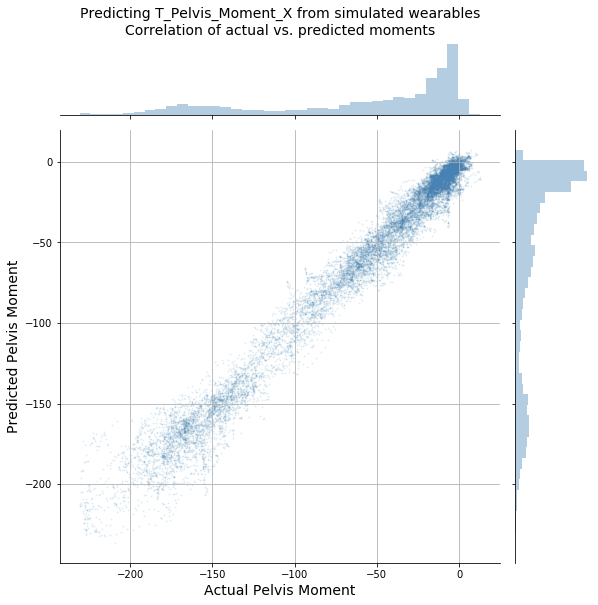

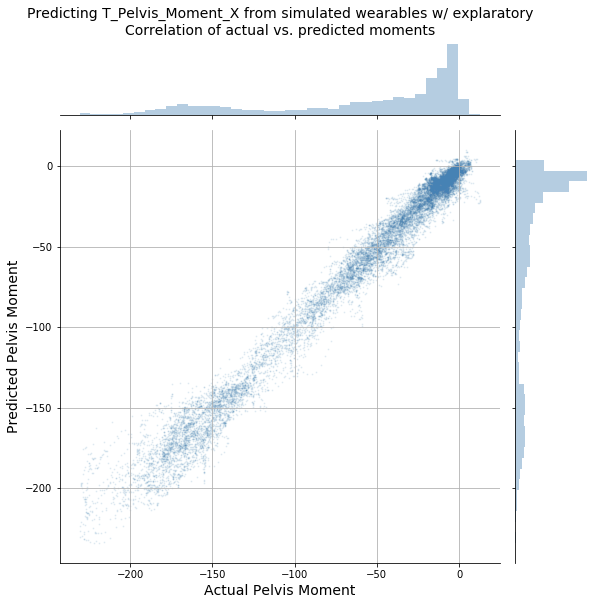

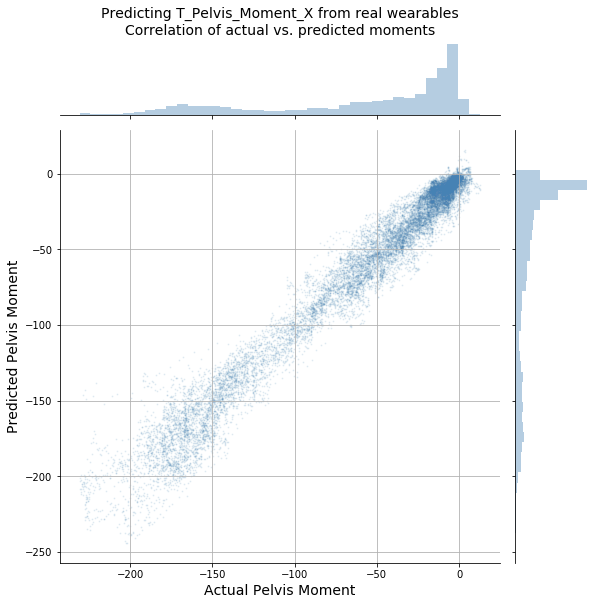

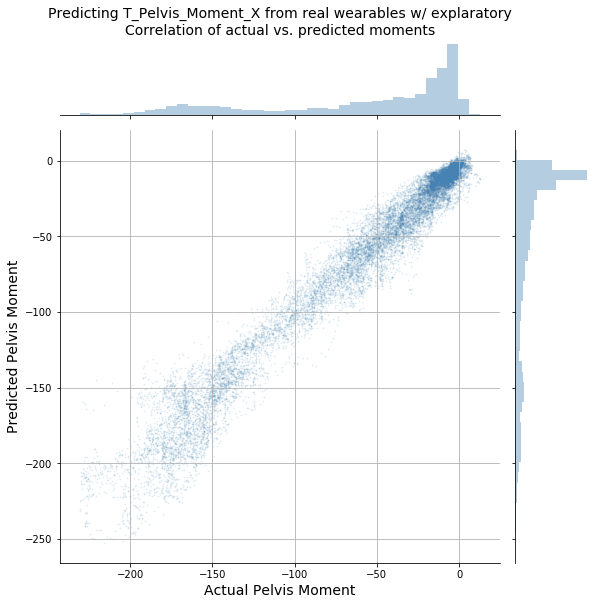

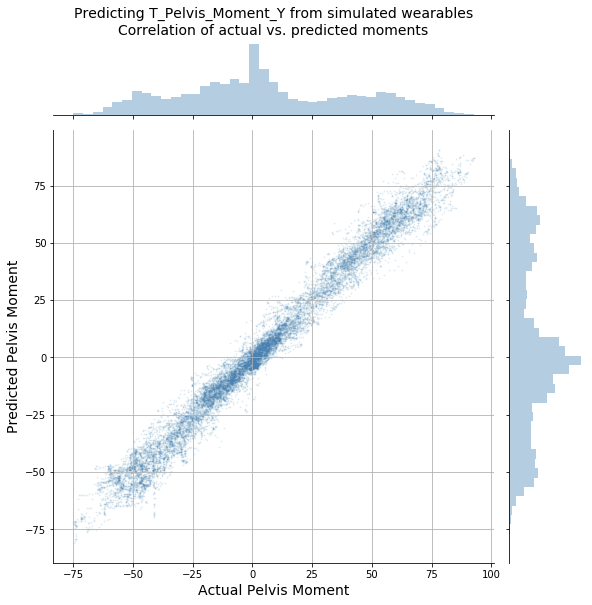

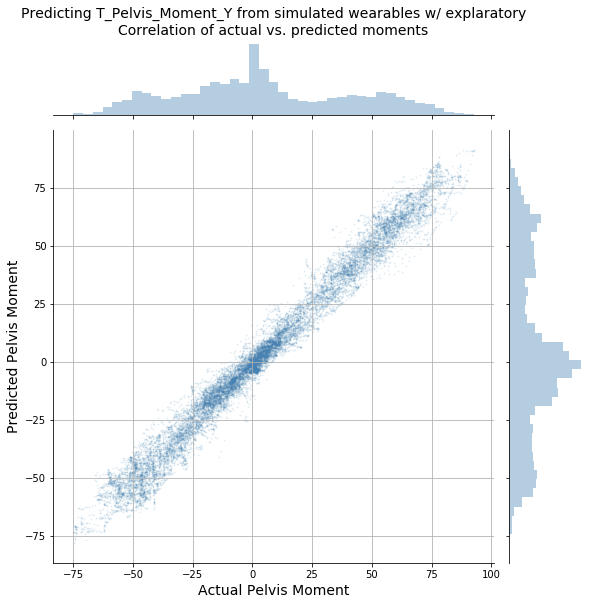

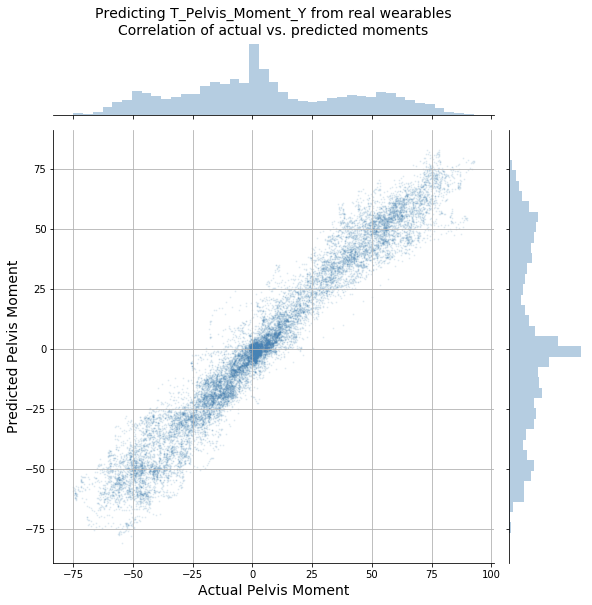

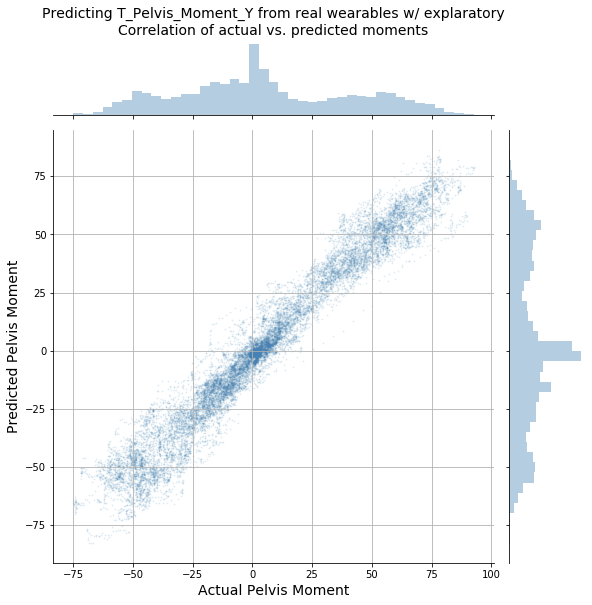

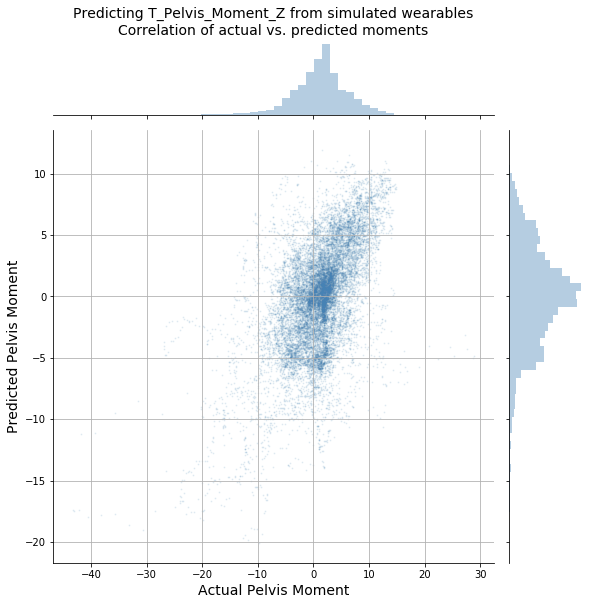

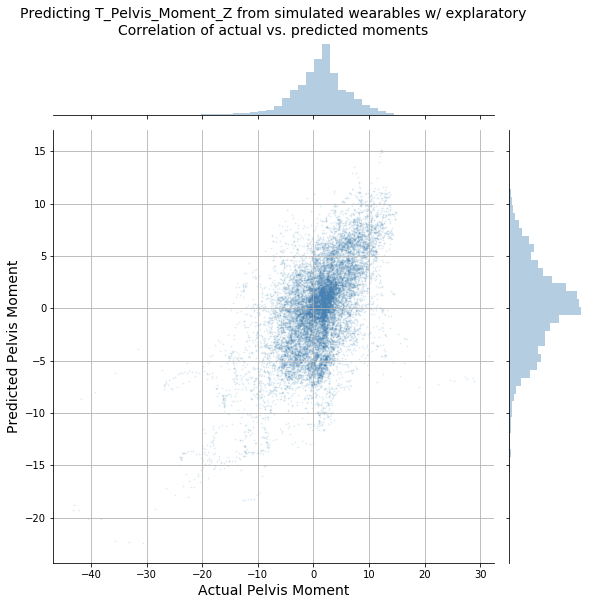

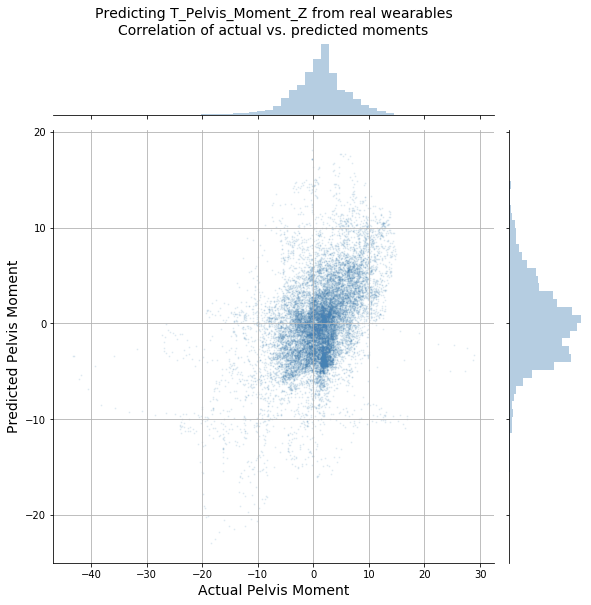

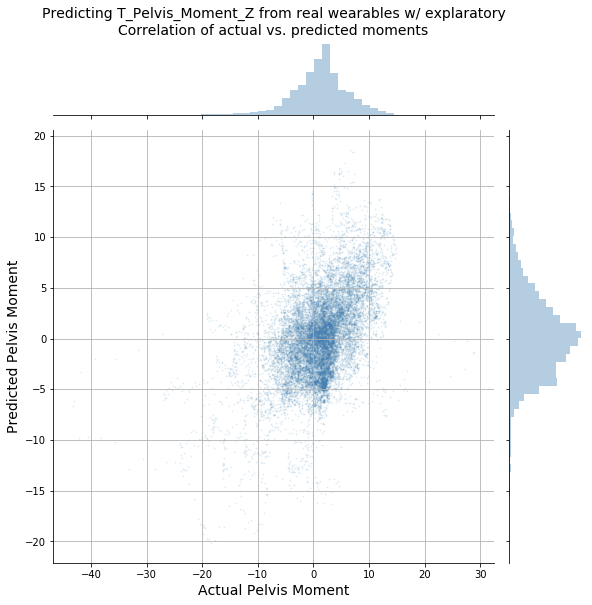

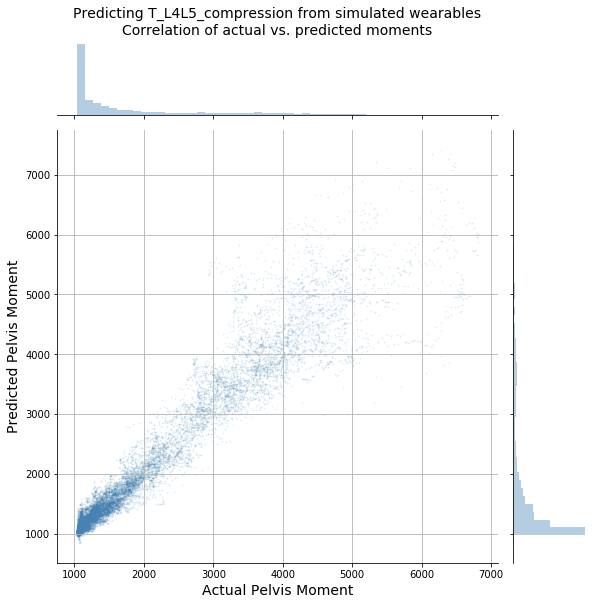

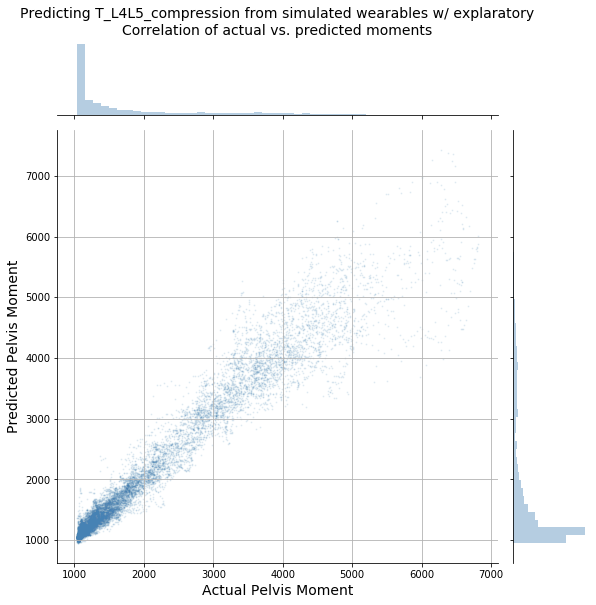

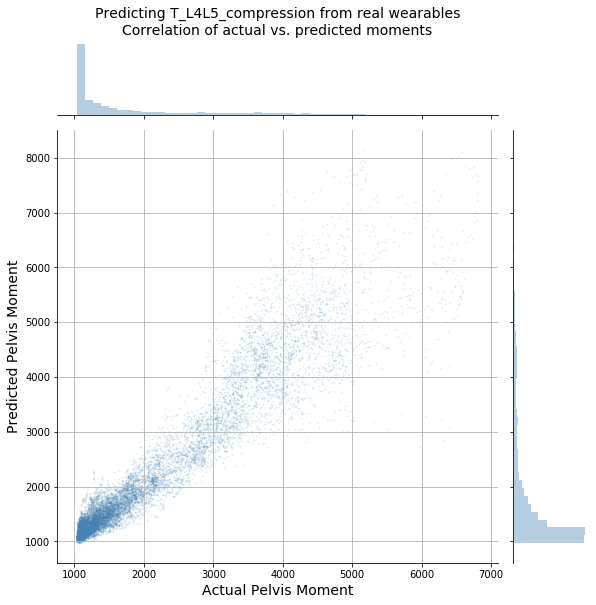

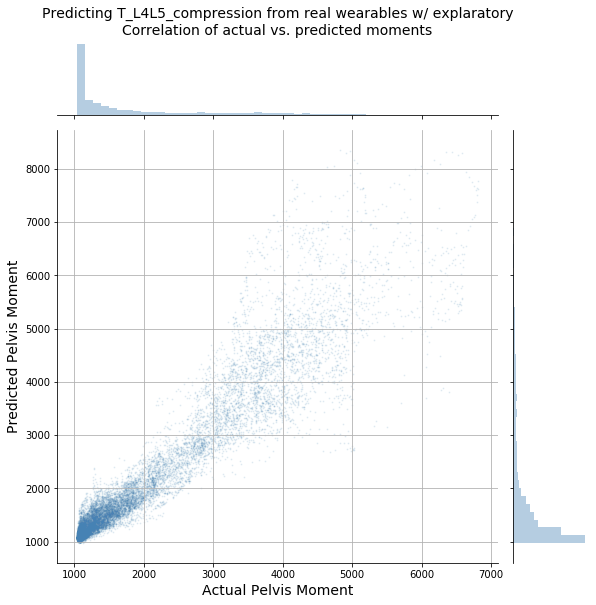

In [40]:
def train_model(X_train, y_train):
    model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('gboost', ensemble.HistGradientBoostingRegressor(max_iter=200))
    ]).fit(X_train, y_train)
    return model
    
def evaluate_model(title, model, X_test, y_test):
    
    print(f"\n{title}:")
    y_test_pred = model.predict(X_test)
    
    # Quantitative results
    mse = metrics.mean_squared_error(y_test_pred, y_test)
    r2 = metrics.r2_score(y_test_pred, y_test)
    print(f"MSE: {mse:.2f}\nRMSE: {np.sqrt(mse):.2f}\nR^2 Score: {r2:.3f}")
    
    # Correlation plot: actual vs. predicted
    ax = sns.jointplot(y_test, y_test_pred, alpha=0.1, s=1.0, color="steelblue", height=8)
    #sns.jointplot(y_test, y_test_pred, kind="hex")
    #sns.jointplot(y_test, y_test_pred, kind="reg")
    ax.set_axis_labels("Actual Pelvis Moment", 'Predicted Pelvis Moment', fontsize=14)
    #ax.ax_joint.legend_.remove()
    ax.ax_joint.grid()
    ax.ax_marg_x.set_title(f"{title}\nCorrelation of actual vs. predicted moments", fontsize=14)

feature_sets = {
    "simulated wearables": get_simulated_predictors(df, explaratory=False),
    "simulated wearables w/ explaratory": get_simulated_predictors(df, explaratory=True),
    "real wearables": get_real_predictors(df, explaratory=False),
    "real wearables w/ explaratory": get_real_predictors(df, explaratory=True)
}

for target_name in get_target_names(df):
    for feature_set, feature_names in feature_sets.items():
        model = train_model(df_train[feature_names], df_train[target_name])
        title = f"Predicting {target_name} from {feature_set}"
        evaluate_model(title, model, df_test[feature_names], df_test[target_name])